In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt

## Load Dataset

In [5]:
df = pd.read_csv('WeatherHistory.csv')

#  basic info and head
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
None
                  Formatted Date        Summary Precip Type  Tem

### Parse Date and Set Index

In [6]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])
df.set_index('Formatted Date', inplace=True)

df.sort_index(inplace=True)

print(df.isnull().sum())

Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64


In [38]:
df.fillna(method='ffill', inplace=True)  # Fhandle miss vlaues

## Seasonal Decomposition

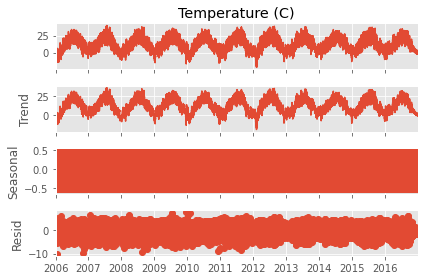

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts, model='additive', period=12)
result.plot()
plt.show()

## Choose KPI 

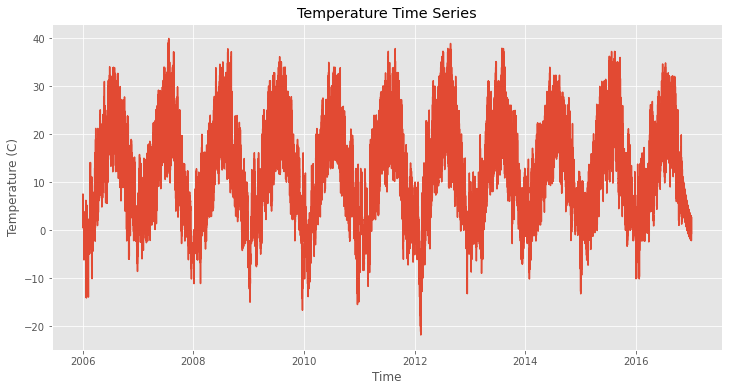

In [42]:
ts = df['Temperature (C)']

plt.figure(figsize=(12,6))
plt.plot(ts)
plt.title('Temperature Time Series')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.show()

## Check Stationarity (ADF Test)

ADF Statistic: -7.391494139936693
p-value: 7.978879290907451e-11


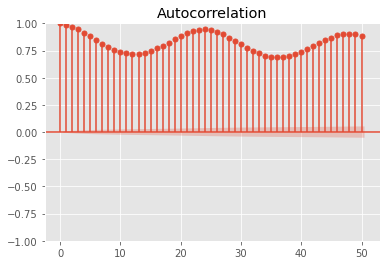

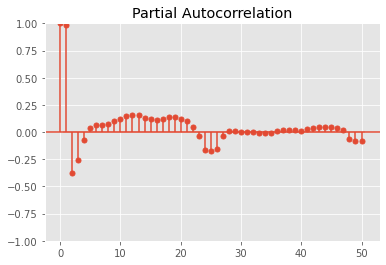

In [43]:
# ADF Test for stationarity
result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

plot_acf(ts)
plot_pacf(ts)
plt.show()

### Since the p-value is extremely low (<0.05) and the ADF Statistic is very negative so the time series is stationary and no differencing is required for modeling.

ADF Statistic (Differenced): -50.706459698295795
p-value (Differenced): 0.0


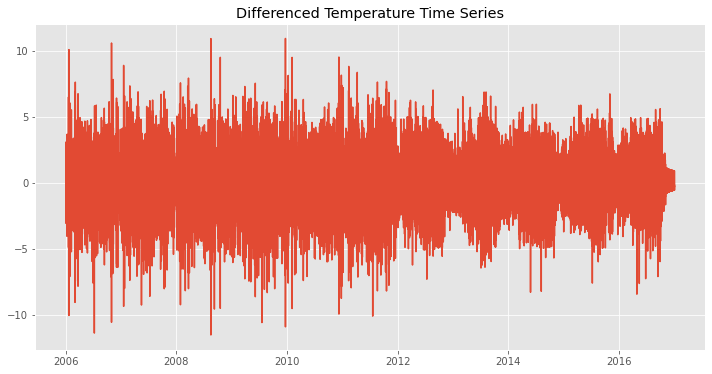

In [44]:
#just to see visualization after differnencing

ts_diff = ts.diff().dropna()

result = adfuller(ts_diff)
print('ADF Statistic (Differenced):', result[0])
print('p-value (Differenced):', result[1])

plt.figure(figsize=(12,6))
plt.plot(ts_diff)
plt.title('Differenced Temperature Time Series')
plt.show()

## Train-Test Split

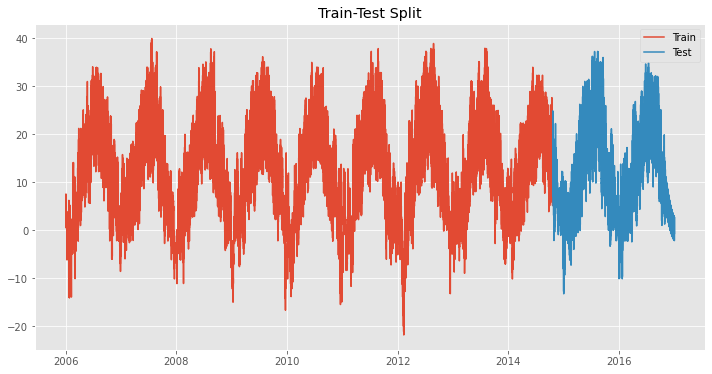

In [45]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('Train-Test Split')
plt.legend()
plt.show()

# Model Implementation

## Exponential Smoothing (ETS)

C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


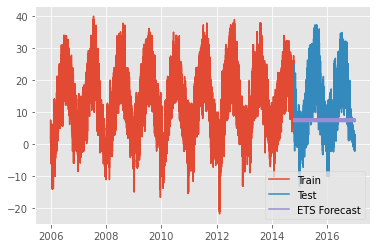

In [46]:
model_ets = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()
forecast_ets = model_ets.forecast(len(test))

# Plot ETS Forecast
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_ets, label='ETS Forecast')
plt.legend()
plt.show()

### Forecasting for next 12 time steps using ETS

C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


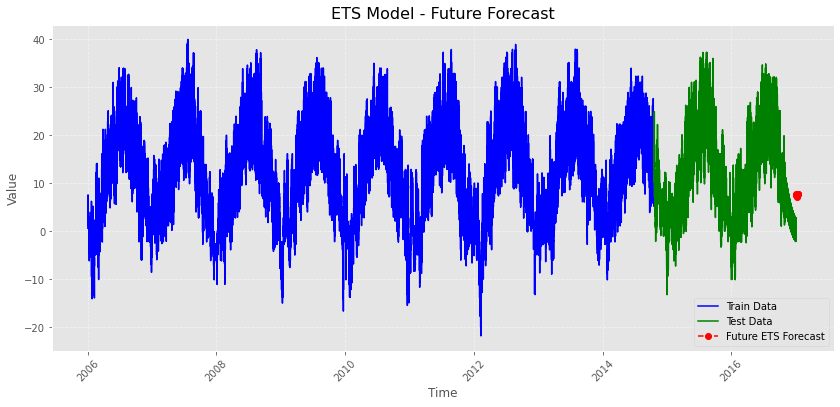

In [47]:
future_periods = 12 

future_index = pd.date_range(start=test.index[-1], periods=future_periods + 1, freq='D')[1:]

future_forecast_ets = model_ets.forecast(future_periods)

# Plot the ETS Forecast
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label='Train Data', color='blue')
plt.plot(test.index, test.values, label='Test Data', color='green')
plt.plot(future_index, future_forecast_ets, label='Future ETS Forecast', color='red', linestyle='--', marker='o')

plt.title('ETS Model - Future Forecast', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

## Auto-Regressive (AR)

C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


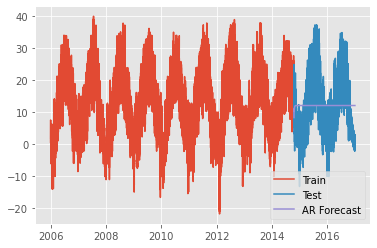

In [48]:
model_ar = AutoReg(train, lags=12).fit()
forecast_ar = model_ar.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_ar, label='AR Forecast')
plt.legend()
plt.show()

### forecasting for next time perios using AR

C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


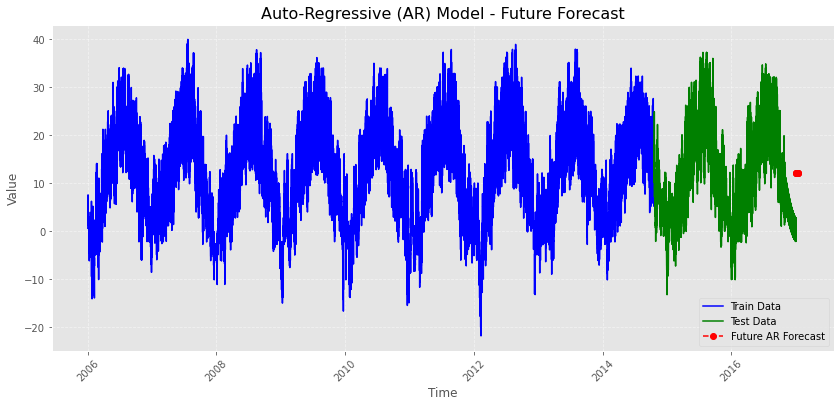

In [50]:
future_periods = 12 

future_index = pd.date_range(start=test.index[-1], periods=future_periods + 1, freq='D')[1:]

future_forecast_ar = model_ar.predict(start=len(train) + len(test), end=len(train) + len(test) + future_periods - 1, dynamic=False)

plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label='Train Data', color='blue')
plt.plot(test.index, test.values, label='Test Data', color='green')
plt.plot(future_index, future_forecast_ar, label='Future AR Forecast', color='red', linestyle='--', marker='o')

plt.title('Auto-Regressive (AR) Model - Future Forecast', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

## Moving Average (MA)

C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results wil

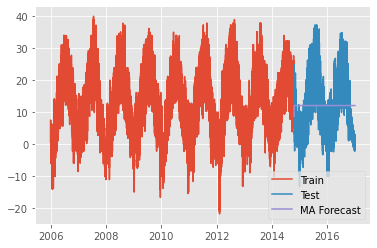

In [51]:
model_ma = ARIMA(train, order=(0,0,1)).fit()
forecast_ma = model_ma.forecast(len(test))

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_ma, label='MA Forecast')
plt.legend()
plt.show()

## ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=243030.538, Time=43.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=275735.886, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=266249.876, Time=1.78 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=269531.293, Time=3.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=275733.886, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=260898.653, Time=7.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=261303.972, Time=8.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=245235.057, Time=51.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=242978.053, Time=65.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=260695.387, Time=10.87 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=242938.870, Time=65.23 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=73.43 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=62.72 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=244458.673, Time=52.58 sec
 ARIMA(4,1,

C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be give

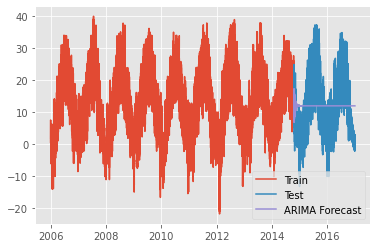

In [52]:
auto_model = auto_arima(train, seasonal=False, trace=True)
print(auto_model.summary())

model_arima = ARIMA(train, order=auto_model.order).fit()
forecast_arima = model_arima.forecast(len(test))

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.legend()
plt.show()

## ARIMA(3,1,3) model  selected as the best fit for the weather dataset based on its lowest AIC value which shoes a good balance between accuracy and complexity.
## However the non-significant coefficients (ar.L2, ma.L2) and residual non-normality suggest that further fine-tuning or exploring  seasonal effects might improve the model.

## Seasonal ARIMA

C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

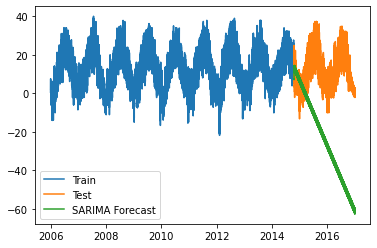

In [15]:
model_sarima = ARIMA(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
forecast_sarima = model_sarima.forecast(len(test))

# Plot SARIMA Forecast
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast')
plt.legend()
plt.show()

## Models Comparison

### Models Evaluations

In [16]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Evaluate all models
results = {
    'ETS': evaluate_model(test, forecast_ets),
    'AR': evaluate_model(test, forecast_ar),
    'MA': evaluate_model(test, forecast_ma),
    'ARIMA': evaluate_model(test, forecast_arima),
    'SARIMA': evaluate_model(test, forecast_sarima),
}

print(pd.DataFrame(results))

               ETS            AR            MA         ARIMA        SARIMA
MAE   7.831407e+00  7.617696e+00  7.621594e+00  7.605864e+00  3.638180e+01
RMSE  9.951919e+00  9.088251e+00  9.090055e+00  9.078768e+00  4.275172e+01
MAPE  3.482320e+13  5.616862e+13  5.611789e+13  5.564466e+13  7.877620e+13


### ARIMA performed the best with the lowest MAE and RMSE which shows higher accuracy in predictions. AR  and MA  followed closely showing similar results. ETS had moderate performance but was outperformed by ARIMA, AR, and MA. SARIMA performed poorly with significantly higher error values across all metrics.

### In terms of MAPE all models displayed unusually high percentage errors, with SARIMA having the worst score.

### ARIMA emerged as the most reliable model, while SARIMA requires further fine-tuning to handle the weather dataset effectively.

## Firecast predictions of all models

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def forecast_future(models, ts, periods=12):
   
    future_index = pd.date_range(start=ts.index[-1], periods=periods + 1, freq='D')[1:]
    forecasts = {}
    
    num_models = len(models)
    rows = num_models
    cols = 1
    
    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * num_models), constrained_layout=True)
    
    if num_models == 1:
        axs = [axs]
    
    for ax, (model_name, model) in zip(axs, models.items()):
        if model_name == 'ETS':
            future_forecast = model.forecast(periods)
        elif model_name == 'AR':
            future_forecast = model.predict(start=len(ts), end=len(ts) + periods - 1)
        elif model_name == 'MA':
            future_forecast = model.forecast(periods)
        elif model_name == 'ARIMA':
            future_forecast = model.forecast(periods)
        elif model_name == 'SARIMA':
            future_forecast = model.forecast(periods)
        else:
            raise ValueError(f"Model {model_name} not supported")
        
        forecasts[model_name] = future_forecast
        
        ax.plot(ts.index, ts.values, label='Historical Data', color='black', linewidth=1.5)
        
        ax.plot(future_index, future_forecast, label=f'{model_name} Forecast', linestyle='--', marker='o')
        
        ax.axvspan(future_index[0], future_index[-1], color='grey', alpha=0.1, label='Forecast Region')
        
        ax.set_title(f'{model_name} Forecast', fontsize=14, fontweight='bold')
        
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Value', fontsize=12)
        
        if len(ts) > 365:
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        elif len(ts) > 30:
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        else:
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        
        ax.tick_params(axis='x', rotation=45) 
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return forecasts

C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mkami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

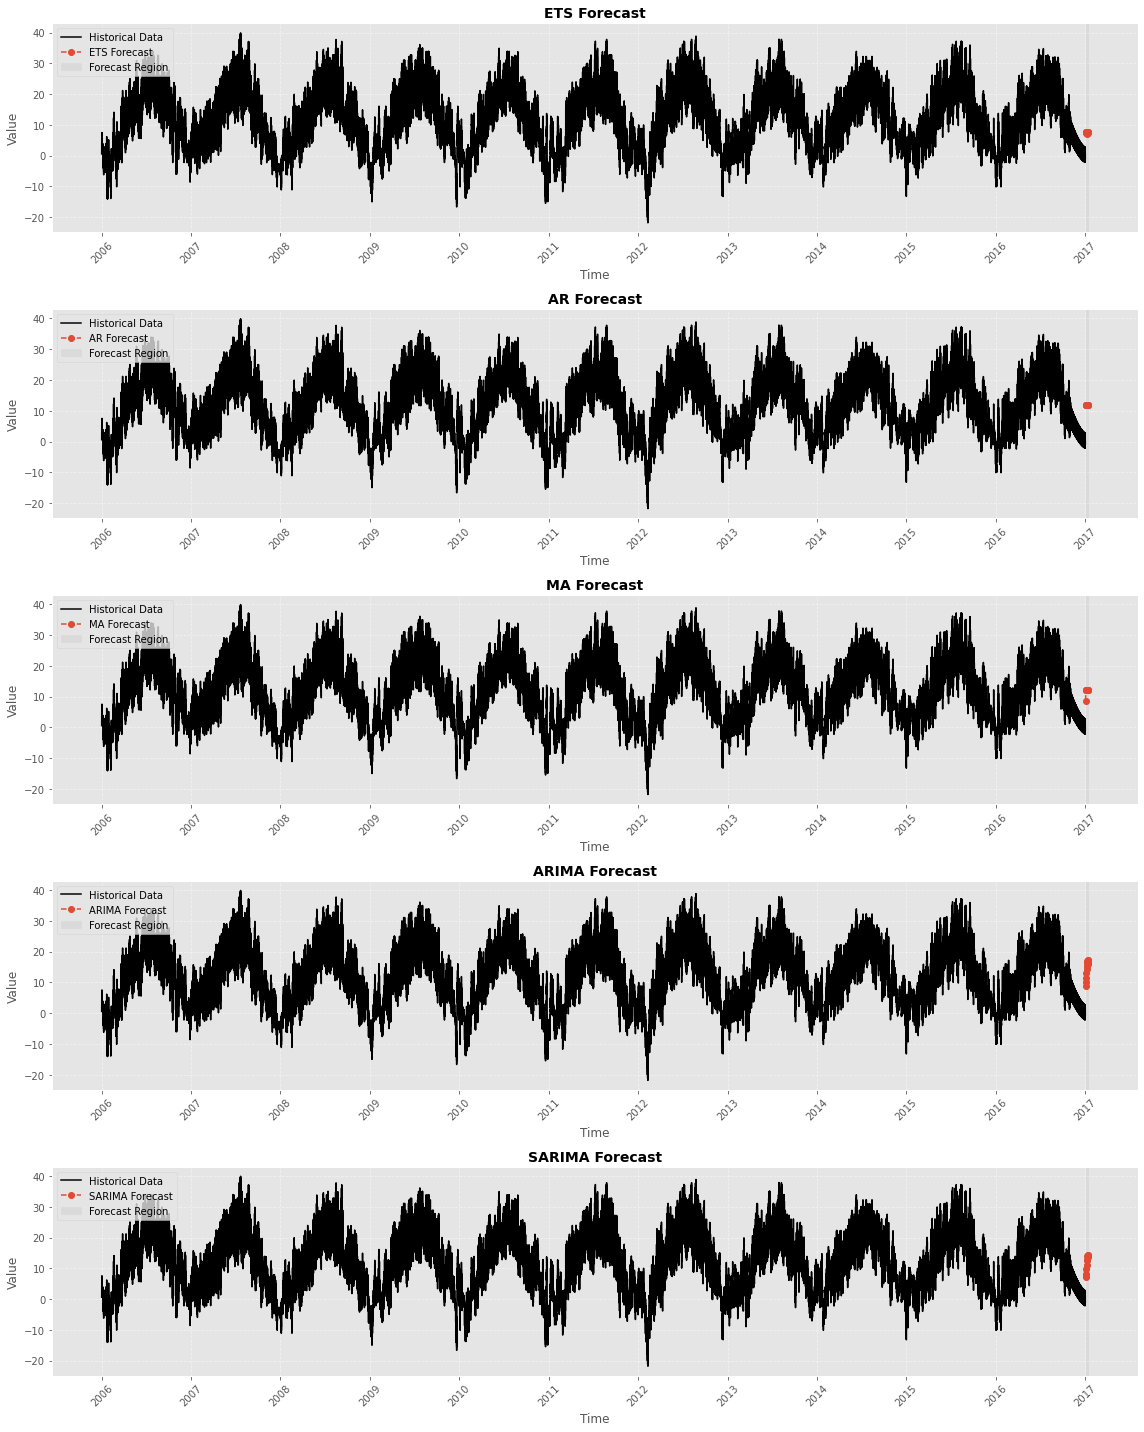

ETS Forecast:
77162    7.533866
77163    7.550877
77164    7.737568
77165    7.591297
77166    7.549434
77167    7.278227
77168    7.073886
77169    7.256995
77170    7.516023
77171    7.697791
77172    7.777210
77173    7.772094
dtype: float64

AR Forecast:
96453    12.02981
96454    12.02981
96455    12.02981
96456    12.02981
96457    12.02981
96458    12.02981
96459    12.02981
96460    12.02981
96461    12.02981
96462    12.02981
96463    12.02981
96464    12.02981
dtype: float64

MA Forecast:
77162     8.667381
77163    12.018945
77164    12.018945
77165    12.018945
77166    12.018945
77167    12.018945
77168    12.018945
77169    12.018945
77170    12.018945
77171    12.018945
77172    12.018945
77173    12.018945
Name: predicted_mean, dtype: float64

ARIMA Forecast:
77162     8.896513
77163    10.164929
77164    11.572764
77165    12.982297
77166    14.319844
77167    15.484497
77168    16.404244
77169    17.015466
77170    17.280110
77171    17.181484
77172    16.728666
77173

In [26]:
trained_models = {
    'ETS': model_ets,
    'AR': model_ar,
    'MA': model_ma,
    'ARIMA': model_arima,
    'SARIMA': model_sarima
}

future_forecasts = forecast_future(trained_models, ts, periods=12)

for model_name, forecast in future_forecasts.items():
    print(f"{model_name} Forecast:\n{forecast}\n")

## The forecasting results show that ARIMA and SARIMA models perform best for given data. ARIMA captures short-term trends effectively while SARIMA handles both trend and seasonality well. ETS provides stable but limited predictions and both AR and MA models fail to adapt to dynamic patterns, producing static forecasts. 
## ARIMA is ideal for capturing trends and SARIMA excels when seasonality is present making them the most reliable choices for weather forecasting.